In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 30
BS = 32

In [3]:
TRAINING_DIR = "data/training"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest")
#                                    preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                         batch_size=BS, 
                                                    target_size=(224, 224))

Found 9880 images belonging to 4 classes.


In [4]:
VALIDATION_DIR = "data/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=BS, 
                                                         target_size=(224, 224))

Found 2472 images belonging to 4 classes.


In [5]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [7]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.hd5f',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')

In [8]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [9]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])


[INFO] compiling model...


In [15]:
# train the head of the network
print("[INFO] training head...")
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlyStopping])

[INFO] training head...
Epoch 1/5
309/309 [==============================] - ETA: 0s - loss: 0.1054 - acc: 0.9627
Epoch 00001: val_loss improved from 0.09992 to 0.09973, saving model to model-001.hd5f
INFO:tensorflow:Assets written to: model-001.hd5f\assets
309/309 [==============================] - 664s 2s/step - loss: 0.1054 - acc: 0.9627 - val_loss: 0.0997 - val_acc: 0.9608
Epoch 2/5
309/309 [==============================] - ETA: 0s - loss: 0.0982 - acc: 0.9673
Epoch 00002: val_loss did not improve from 0.09973
309/309 [==============================] - 613s 2s/step - loss: 0.0982 - acc: 0.9673 - val_loss: 0.1006 - val_acc: 0.9612
Epoch 3/5
309/309 [==============================] - ETA: 0s - loss: 0.0944 - acc: 0.9671
Epoch 00003: val_loss improved from 0.09973 to 0.09706, saving model to model-003.hd5f
INFO:tensorflow:Assets written to: model-003.hd5f\assets
309/309 [==============================] - 642s 2s/step - loss: 0.0944 - acc: 0.9671 - val_loss: 0.0971 - val_acc: 0.9628
E

In [16]:
model.save("MObileNet_Top_FAlse_model_2_96")

INFO:tensorflow:Assets written to: MObileNet_Top_FAlse_model_2_96\assets


In [17]:
import matplotlib.pyplot as plt

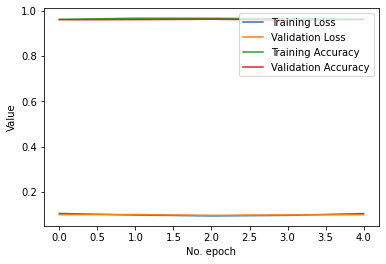

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()